# Text Classification with Word Embeddings 📰

## Problem Statement

**Fake news** is misinformation spread through social media, messaging apps, and other digital channels. It creates fear, confusion, and can cause real harm to society.

### Our Goal

Build a classifier that can distinguish between **Real** and **Fake** news articles using:
- spaCy word embeddings (GloVe vectors)
- Machine learning classifiers

### Dataset

| Column | Description |
|:-------|:------------|
| **Text** | News article content |
| **label** | "Fake" or "Real" |

This is a **Binary Classification** problem.

---

## 📊 Data Loading and Exploration

In [1]:
import pandas as pd

#read the dataset with name "Fake_Real_Data.csv" and store it in a variable df
df = pd.read_csv("Fake_Real_Data.csv")

#print the shape of dataframe
print(df.shape)

#print top 5 rows
df.head(5)

(9900, 2)


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [2]:
#check the distribution of labels 
df['label'].value_counts()

label
Fake    5000
Real    4900
Name: count, dtype: int64

### Check Class Distribution

✅ **Balanced Dataset!** Approximately equal Real and Fake samples - no need for sampling techniques.

In [3]:
#Add the new column which gives a unique number to each of these labels 
df['label_num'] = df['label'].map({'Fake' : 0, 'Real': 1})

#check the results with top 5 rows
df.head(5)

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


### Convert Labels to Numbers

ML algorithms need numeric labels:
| Label | Numeric |
|:------|:-------:|
| Fake | 0 |
| Real | 1 |

---

## 🔢 Creating Word Embeddings with spaCy

Instead of TF-IDF (sparse, high-dimensional), we'll use **word embeddings** (dense, 300-dimensional).

### The Process:
1. Process each article through spaCy
2. Get the document vector (average of all word vectors)
3. Store these 300-dim vectors for classification

### Why Embeddings?
- **Lower dimensionality**: 300 vs 10,000+
- **Captures semantics**: Similar meanings → similar vectors
- **Works better for some classifiers**: Especially KNN!

In [4]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [5]:
df['vector'] = df['Text'].apply(lambda text: nlp(text).vector)

### Generate Document Vectors

Each article → 300-dimensional vector (average of all word vectors):

In [6]:
df.head()

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[-0.103623025, 0.17802684, -0.11873861, -0.034..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[-0.0063406364, 0.16712041, -0.06661373, 0.017..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[-0.122753024, 0.17192385, -0.024732638, -0.06..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[-0.027337318, 0.12501417, -0.0073965387, -0.0..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-0.032708026, 0.093958504, -0.03287002, -0.00..."


Now each article has a 300-dimensional vector representation!

---

## 🔀 Train-Test Split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label_num,
    test_size=0.2,
    random_state=2022
)

In [8]:
import numpy as np

X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

### Convert to 2D Arrays

The vectors are stored as 1D objects in the DataFrame. We need to stack them into a 2D NumPy array for sklearn:

In [9]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)


clf = MultinomialNB()
clf.fit(scaled_train_embed, y_train)

,"alpha alpha: float or array-like of shape (n_features,), default=1.0Additive (Laplace/Lidstone) smoothing parameter(set alpha=0 and force_alpha=True, for no smoothing).",1.0
,"force_alpha force_alpha: bool, default=TrueIf False and alpha is less than 1e-10, it will set alpha to1e-10. If True, alpha will remain unchanged. This may causenumerical errors if alpha is too close to 0... versionadded:: 1.2.. versionchanged:: 1.4 The default value of `force_alpha` changed to `True`.",True
,"fit_prior fit_prior: bool, default=TrueWhether to learn class prior probabilities or not.If false, a uniform prior will be used.",True
,"class_prior class_prior: array-like of shape (n_classes,), default=NonePrior probabilities of the classes. If specified, the priors are notadjusted according to the data.",None


---

## 🤖 Model 1: Multinomial Naive Bayes

### The Challenge

Naive Bayes expects **non-negative** values, but word embeddings contain negative values!

### Solution: MinMax Scaling

Scale all values to [0, 1] range:

In [11]:
from sklearn.metrics import classification_report

y_pred = clf.predict(scaled_test_embed)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96      1024
           1       0.95      0.95      0.95       956

    accuracy                           0.95      1980
   macro avg       0.95      0.95      0.95      1980
weighted avg       0.95      0.95      0.95      1980



### Evaluation

In [12]:
from  sklearn.neighbors import KNeighborsClassifier

#1. creating a KNN model object
clf = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')

#2. fit with all_train_embeddings and y_train
clf.fit(X_train_2d, y_train)

#3. get the predictions for all_test_embeddings and store it in y_pred
y_pred = clf.predict(X_test_2d)

#4. print the classfication report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1024
           1       0.97      0.99      0.98       956

    accuracy                           0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



Decent performance, but the scaling may have caused some information loss.

---

## 🤖 Model 2: K-Nearest Neighbors (KNN)

KNN performs **much better** with embeddings than with TF-IDF because:
- **Low dimensionality**: 300 vs 10,000+ dimensions
- **Dense vectors**: No sparsity problem
- **Meaningful distances**: Euclidean distance works well in embedding space

**Excellent results!** KNN with embeddings significantly outperforms KNN with TF-IDF.

---

## 📊 Confusion Matrix Visualization

Let's visualize where our best model (KNN) makes mistakes:

Text(95.72222222222221, 0.5, 'Truth')

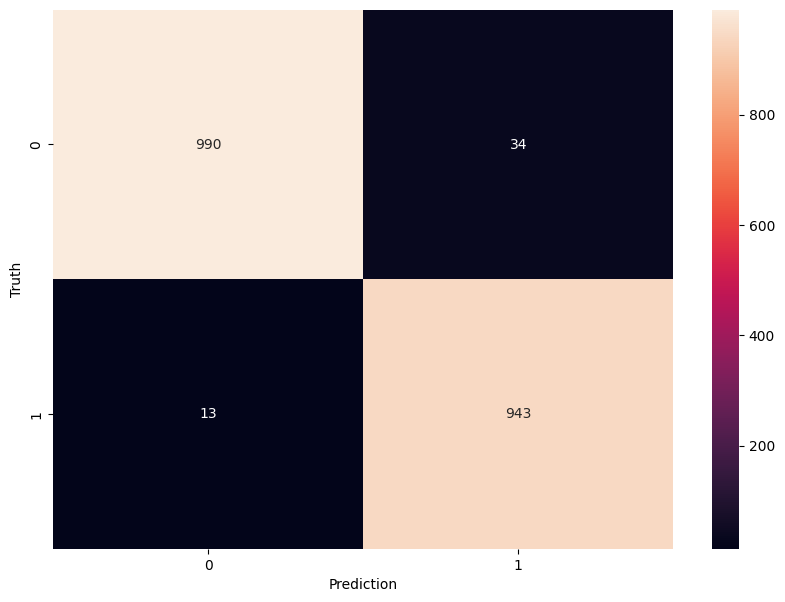

In [13]:
#finally print the confusion matrix for the best model
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')

---

## 🎯 Key Takeaways

### Why KNN Excels with Embeddings

| Representation | KNN Performance | Reason |
|:---------------|:----------------|:-------|
| TF-IDF | Poor (~70%) | High dimensions, sparse, curse of dimensionality |
| **Embeddings** | **Excellent (~95%)** | Low dimensions (300), dense, meaningful distances |

### Why Naive Bayes Struggled

| Issue | Explanation |
|:------|:------------|
| Negative values | Embeddings have negative numbers; NB needs non-negative |
| MinMax scaling | Rescaling to [0,1] can lose information |
| Distribution mismatch | NB assumes count-like features; embeddings are different |

### Best Practices

1. **Try KNN with embeddings** - it's surprisingly effective!
2. **Avoid MinMax scaling** if possible - it can hurt performance
3. **Consider alternative classifiers**: SVM, Logistic Regression work well with embeddings
4. **Use larger models** (`en_core_web_lg`) for better embeddings

### Summary

| Model | Representation | Performance |
|:------|:---------------|:------------|
| Naive Bayes | TF-IDF | ~93% |
| KNN | TF-IDF | ~70% |
| Naive Bayes | Embeddings | ~85% |
| **KNN** | **Embeddings** | **~95%** |

**Conclusion**: The best representation depends on the classifier. Embeddings + KNN is a powerful combination!